In [1]:
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pygeohash as pgh
import os

In [61]:
# Prepare data for XG Boost


In [62]:
df = pd.read_csv('original_dataset_merged_RNN_w_noflared.csv')

columns = ['wellpad_code','area_m2','wells','parent_operator_co','lat','long', 'state', 'basin', 'subbasin', 'county', 'company_type',
           'tst_first_detection_date', 'tst_permit_date', 'tst_permit_published_date', 'tst_spud_date', 
           'tst_completion_date', 'tst_fracfocus_jobstart_date', 'tst_fracfocus_jobend_date',
           'wellpad_vintage_year', 'aq_date', 'power','BRIGHTNESS','days_diffs','temporal_group','pad_status']

df1 = df[columns].copy()

def is_correct_dt(dt_str):
    
    try:
        dt = datetime.strptime(dt_str, '%Y/%m/%d')
    except:
        dt = np.nan
    
    return dt
    
df1['tst_first_detection_date'] = df1['tst_first_detection_date'].apply(is_correct_dt)


KeyError: "['aq_date', 'power', 'BRIGHTNESS', 'days_diffs', 'temporal_group'] not in index"

In [ ]:
df1['aq_date'] = pd.to_datetime(df1['aq_date'], format='%Y%m%d %H:%M')
df1['tst_first_detection_date'] = pd.to_datetime(df1['tst_first_detection_date'], format='%Y/%m/%d')
df1['tst_permit_date'] = pd.to_datetime(df1['tst_permit_date'], format='%Y/%m/%d')
df1['tst_permit_published_date'] = pd.to_datetime(df1['tst_permit_published_date'], format='%Y/%m/%d')
df1['tst_spud_date'] = pd.to_datetime(df1['tst_spud_date'], format='%Y/%m/%d')
df1['tst_completion_date'] = pd.to_datetime(df1['tst_completion_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobstart_date'] = pd.to_datetime(df1['tst_fracfocus_jobstart_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date'], format='%Y/%m/%d')


In [ ]:
df1

In [ ]:
def public_private_class(company_type):
    
    ctype_class = 0
    if company_type == 'Public':
        ctype_class = 1
        
    return ctype_class

df1['company_type'] = df1['company_type'].apply(public_private_class)

In [ ]:
# Find minimum date
sub_df = df1[['tst_first_detection_date', 'tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date',
             'tst_fracfocus_jobend_date']].copy()
sub_df['t0'] = sub_df.min(axis = 1)
df1['t0'] = sub_df['t0']

# Find max date

sub_df = df1[['tst_first_detection_date', 'tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date',
             'tst_fracfocus_jobend_date', 'aq_date']].copy()
sub_df['tmax'] = sub_df.max(axis = 1)

df1['tmax'] = sub_df['tmax']


In [ ]:
df1

In [ ]:
# Convert everything to standard dates

df1['aq_date'] = pd.to_datetime(df1['aq_date']).dt.date
df1['tst_first_detection_date'] = pd.to_datetime(df1['tst_first_detection_date']).dt.date
df1['tst_permit_date'] = pd.to_datetime(df1['tst_permit_date']).dt.date
df1['tst_permit_published_date'] = pd.to_datetime(df1['tst_permit_published_date']).dt.date
df1['tst_spud_date'] = pd.to_datetime(df1['tst_spud_date']).dt.date
df1['tst_completion_date'] = pd.to_datetime(df1['tst_completion_date']).dt.date
df1['tst_fracfocus_jobstart_date'] = pd.to_datetime(df1['tst_fracfocus_jobstart_date']).dt.date
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date']).dt.date
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date']).dt.date
df1['t0'] = pd.to_datetime(df1['t0']).dt.date
df1['tmax'] = pd.to_datetime(df1['tmax']).dt.date


In [ ]:
df1

In [ ]:
# create correlation table
corr_tb = df1.corr()

# create mask
mask = np.zeros_like(corr_tb, dtype=np.bool)
mask[np.triu_indices_from(mask, k=0)] = True

# generate colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# initialise figure
f, ax = plt.subplots(figsize=(11, 9))

# draw heatmap
sns.heatmap(corr_tb, mask=mask, cmap=cmap, center=0, 
            annot=True, square=True, linewidths=.5) 

# show figure
plt.show()

In [ ]:
# Simulate Daily Time series per wellpad

wellpad_groups = df1.groupby('wellpad_code')

In [ ]:
wellpad_groups

In [ ]:
def flare_check(rows, todays_date):

    todays_date = todays_date.date()
    
    is_flaring = 0
    flares_n_acc = 0 # Number of flares so far
    flares_power_acc = 0 # Total FRP so far
    flares_power = 0
    temporal_group = np.nan
    #t_until_next_flare = np.nan # Time until next flaring event
    t_since_last_flare = np.nan # Time since last flare event
    #flares_future_n = 0 # Number of flares in the future
    #flares_future_power = 0 # Total FRP in the future
    
    rows_today_and_before = rows.loc[rows['aq_date'] <= todays_date] # Get rows today and before
    #rows_future = rows.loc[rows['aq_date'] > todays_date] # Get future rows
    
    
    if len(rows_today_and_before) > 0: # Do we have any flaring data today or before?
        
        flares_n_acc = len(rows_today_and_before)
        flares_power = rows_today_and_before.power.values[0]
        temporal_group = rows_today_and_before.temporal_group.values[0]
        flares_power_acc = rows_today_and_before.power.sum()
        most_recent_flare = rows_today_and_before.sort_values('aq_date', ascending=False).head(1)
        t_since_last_flare = (todays_date-most_recent_flare['aq_date'].values[0]).days
        
        if (todays_date ==  most_recent_flare['aq_date'].values[0]):
            is_flaring = 1
        else:
            flares_power = 0
        
#     if len(rows_future) > 0: # Do we have any flaring data after today?
        
#         flares_future_n = len(rows_future)
#         flares_future_power = rows_future.power.sum()
#         next_flare = rows_future.sort_values('aq_date', ascending=True).head(1)
#         t_until_next_flare = (next_flare['aq_date'].values[0]-todays_date).days


    return flares_n_acc, flares_power,flares_power_acc,t_since_last_flare,is_flaring,temporal_group  #,flares_future_n, flares_future_power,t_until_next_flare
    
    
def spud_check(rows, todays_date):

    # Get first row
    row = rows.head(1)
    
    t_spud_diff = np.nan
    
    spud_date = row['tst_spud_date'].values[0]
    todays_date = todays_date.date()
    
    if spud_date is not pd.NaT:
        if spud_date <= todays_date:

            t_spud_diff = (todays_date-spud_date).days
            
    return t_spud_diff


def completion_check(rows, todays_date):
    
    # Get first row
    row = rows.head(1)
    
    n_completions = 0
    t_comp_diff = np.nan
    
    comp_diffs = []
    
    todays_date = todays_date.date()
    
    tst_completion_date = row['tst_completion_date'].values[0]
     
    if tst_completion_date is not pd.NaT:
        if tst_completion_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_completion_date).days)
    
    
    
    tst_fracfocus_jobstart_date = row['tst_fracfocus_jobstart_date'].values[0]
    
    if tst_fracfocus_jobstart_date is not pd.NaT:
        if tst_fracfocus_jobstart_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_fracfocus_jobstart_date).days)

            
            
    tst_fracfocus_jobend_date = row['tst_fracfocus_jobend_date'].values[0]
    
    if tst_fracfocus_jobend_date is not pd.NaT:
        if tst_fracfocus_jobend_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_fracfocus_jobend_date).days)
      
    
    if len(comp_diffs) > 0:
        t_comp_diff = min(comp_diffs)
        
    return n_completions, t_comp_diff


In [ ]:
df1.columns

In [59]:
df1

,wellpad_code,area_m2,wells,parent_operator_co,lat,long,state,basin,subbasin,county,...,tst_fracfocus_jobend_date,wellpad_vintage_year,aq_date,power,BRIGHTNESS,days_diffs,temporal_group,pad_status,t0,tmax
0,9txqyd3v,20400.651830,3.0,CROWNQUEST OPERATING,32.1372,-102.0163,Texas,Permian,Midland,Martin,...,2019-04-11,2018,2019-07-03,2.53,302.01,68.0,1.0,6,2018-05-06,2019-07-03
1,9txqydx8,35254.991310,3.0,CROWNQUEST OPERATING,32.1379,-102.0083,Texas,Permian,Midland,Martin,...,2022-01-17,2021,2022-04-04,1.62,303.60,910.0,3.0,6,2020-09-17,2022-04-04
2,9txqyf9e,31574.652690,6.0,CROWNQUEST OPERATING,32.1385,-102.0056,Texas,Permian,Midland,Martin,...,2021-12-31,2020,2022-04-04,1.78,315.40,0.0,3.0,6,2020-08-13,2022-04-04
3,9txqyf9e,31574.652690,6.0,CROWNQUEST OPERATING,32.1385,-102.0056,Texas,Permian,Midland,Martin,...,2021-12-31,2020,2022-04-04,0.79,297.20,0.0,3.0,6,2020-08-13,2022-04-04
4,9txqyf9e,31574.652690,6.0,CROWNQUEST OPERATING,32.1385,-102.0056,Texas,Permian,Midland,Martin,...,2021-12-31,2020,2022-04-06,5.49,367.00,2.0,3.0,6,2020-08-13,2022-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154112,9tz7mnen,14609.213250,1.0,SMITH ENERGY OPERATING,32.9518,-102.0808,Texas,Permian,Midland,Dawson,...,2022-05-25,2022,NaT,NaN,NaN,NaN,NaN,6,2022-02-07,2022-06-10
154113,9trx874v,7889.643735,1.0,KINDER MORGAN,30.8672,-101.9379,Texas,Permian,NaN,Pecos,...,NaT,2022,NaT,NaN,NaN,NaN,NaN,4,2021-12-15,2022-03-11
154114,9trx86q0,6531.521689,1.0,KINDER MORGAN,30.8622,-101.9335,Texas,Permian,NaN,Pecos,...,NaT,2022,NaT,NaN,NaN,NaN,NaN,4,2021-12-21,2022-03-22
154115,9twm9n10,19650.933560,1.0,NGL ENERGY,31.9369,-103.6653,Texas,Permian,Delaware,Loving,...,NaT,2022,NaT,NaN,NaN,NaN,NaN,4,2021-12-07,2022-06-28


In [43]:
from tqdm.notebook import tqdm


group_inc = 0
list_wellpad=[]

for g in tqdm(wellpad_groups):
    
    
#     print(str(group_inc)+'/'+str(len(wellpad_groups)))
    
    rows = g[1].sort_values('aq_date', ascending=False)
    
    # Fixed variables
    company_type = rows['company_type'].values[0]
    area_m2 = rows['area_m2'].values[0]
    state = rows['state'].values[0]
    basin = rows['basin'].values[0]
    subbasin = rows['subbasin'].values[0]
    county = rows['county'].values[0]
    wellpad_vintage_year = rows['wellpad_vintage_year'].values[0]
    
    wells = rows['wells'].values[0]
    parent_operator_co = rows['parent_operator_co'].values[0]
    
    
    
    # Interpolate and cycle through all possible days between t0 and tmax
    
    t0 = rows['t0'].values[0] # Where we start daily increments
    tmax = rows['tmax'].values[0] # Where we end daily increments

    t_inc = 0 # What day we are on relative to t0
    delta = tmax - t0
    n_days = delta.days # Number of days in this wellpad sample


    wellpad_daily_event_df = pd.DataFrame({
            'company_type': [company_type], #  
            'area_m2': [area_m2], # 
            'state': [state], # 
            'basin': [basin], # 
            'subbasin': [subbasin], # 
            'county': [county], # 
            'wellpad_vintage_year': [wellpad_vintage_year], #
        
            'wells': [wells], #  
            'parent_operator_co': [parent_operator_co] # 
        
   
        })

    for n in range(0, int(n_days)+1):

        todays_date = t0+pd.DateOffset(days=n)

        #flares_n, flares_power, t_until_next_flare, t_since_last_flare, flares_future_n, flares_future_power, is_flaring = flare_check(rows, todays_date)
        #flares_n, flares_power, t_since_last_flare, is_flaring,temporal_group = flare_check(rows, todays_date)
        flares_n_acc, flares_power,flares_power_acc,t_since_last_flare,is_flaring,temporal_group = flare_check(rows, todays_date)

        t_spud_diff = spud_check(rows, todays_date)
        n_completions, t_comp_diff = completion_check(rows, todays_date)
        
        #temporal_group = rows['temporal_group'].values[0]

        daily_event_record = pd.DataFrame({
            't_n': [n], # Days since t0  
            'flares_n_acc': [flares_n_acc], # Number of flares so far
            'flares_power_acc': [flares_power_acc], # Total FRP so far
            'flares_power': [flares_power], #  FRP 
            'n_completions': [n_completions], # Number of completions so far
            't_comp_diff': [t_comp_diff], # Days since last completion
            't_spud_diff': [t_spud_diff], # Days since spud event
            'temporal_group': [temporal_group],
            'is_flaring': [is_flaring] # Is currently flaring
           # 't_until_next_flare': [t_until_next_flare], # Y predict
           # 't_since_last_flare': [t_since_last_flare], # Y predict
           # 'flares_future_n': [flares_future_n], # Y predict
           # 'flares_future_power': [flares_future_power], # Y predict
        })

        wellpad_daily_event_df = pd.concat([wellpad_daily_event_df, daily_event_record])

        wellpad_daily_event_df.to_csv((str(g[0])+'.csv'), index=False)
        list_wellpad.append(str(g[0])) 
        
    group_inc+=1
        
        

  0%|          | 0/4103 [00:00<?, ?it/s]

In [2]:
df = pd.read_csv('original_dataset_merged_RNN_only_noflared.csv')

columns = ['wellpad_code','area_m2','wells','parent_operator_co','lat','long', 'state', 'basin', 'subbasin', 'county', 'company_type',
           'tst_first_detection_date', 'tst_permit_date', 'tst_permit_published_date', 'tst_spud_date', 
           'tst_completion_date', 'tst_fracfocus_jobstart_date', 'tst_fracfocus_jobend_date',
           'wellpad_vintage_year']

df1 = df[columns].copy()

def is_correct_dt(dt_str):
    
    try:
        dt = datetime.strptime(dt_str, '%Y/%m/%d')
    except:
        dt = np.nan
    
    return dt
    
df1['tst_first_detection_date'] = df1['tst_first_detection_date'].apply(is_correct_dt)


In [3]:

df1['tst_first_detection_date'] = pd.to_datetime(df1['tst_first_detection_date'], format='%Y/%m/%d')
df1['tst_permit_date'] = pd.to_datetime(df1['tst_permit_date'], format='%Y/%m/%d')
df1['tst_permit_published_date'] = pd.to_datetime(df1['tst_permit_published_date'], format='%Y/%m/%d')
df1['tst_spud_date'] = pd.to_datetime(df1['tst_spud_date'], format='%Y/%m/%d')
df1['tst_completion_date'] = pd.to_datetime(df1['tst_completion_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobstart_date'] = pd.to_datetime(df1['tst_fracfocus_jobstart_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date'], format='%Y/%m/%d')
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date'], format='%Y/%m/%d')


In [4]:
def public_private_class(company_type):
    
    ctype_class = 0
    if company_type == 'Public':
        ctype_class = 1
        
    return ctype_class

df1['company_type'] = df1['company_type'].apply(public_private_class)

In [5]:
# Find minimum date
sub_df = df1[['tst_first_detection_date', 'tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date',
             'tst_fracfocus_jobend_date']].copy()
sub_df['t0'] = sub_df.min(axis = 1)
df1['t0'] = sub_df['t0']

# Find max date

sub_df = df1[['tst_first_detection_date', 'tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date',
             'tst_fracfocus_jobend_date']].copy()
sub_df['tmax'] = sub_df.max(axis = 1)

df1['tmax'] = sub_df['tmax']


In [6]:

df1['tst_first_detection_date'] = pd.to_datetime(df1['tst_first_detection_date']).dt.date
df1['tst_permit_date'] = pd.to_datetime(df1['tst_permit_date']).dt.date
df1['tst_permit_published_date'] = pd.to_datetime(df1['tst_permit_published_date']).dt.date
df1['tst_spud_date'] = pd.to_datetime(df1['tst_spud_date']).dt.date
df1['tst_completion_date'] = pd.to_datetime(df1['tst_completion_date']).dt.date
df1['tst_fracfocus_jobstart_date'] = pd.to_datetime(df1['tst_fracfocus_jobstart_date']).dt.date
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date']).dt.date
df1['tst_fracfocus_jobend_date'] = pd.to_datetime(df1['tst_fracfocus_jobend_date']).dt.date
df1['t0'] = pd.to_datetime(df1['t0']).dt.date
df1['tmax'] = pd.to_datetime(df1['tmax']).dt.date

C:\Users\Shihao Zhou\AppData\Local\Temp\ipykernel_4468\3801110328.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_tb, dtype=np.bool)


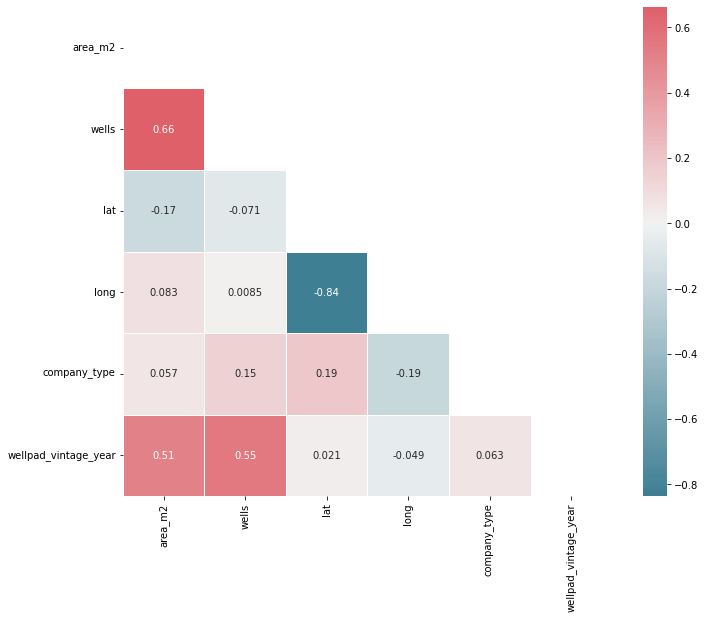

In [7]:
# create correlation table
corr_tb = df1.corr()

# create mask
mask = np.zeros_like(corr_tb, dtype=np.bool)
mask[np.triu_indices_from(mask, k=0)] = True

# generate colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# initialise figure
f, ax = plt.subplots(figsize=(11, 9))

# draw heatmap
sns.heatmap(corr_tb, mask=mask, cmap=cmap, center=0, 
            annot=True, square=True, linewidths=.5) 

# show figure
plt.show()

In [8]:
df1

,wellpad_code,area_m2,wells,parent_operator_co,lat,long,state,basin,subbasin,county,...,tst_first_detection_date,tst_permit_date,tst_permit_published_date,tst_spud_date,tst_completion_date,tst_fracfocus_jobstart_date,tst_fracfocus_jobend_date,wellpad_vintage_year,t0,tmax
0,9txvg2y7,25620.717730,1.0,APA,31.9530,-101.4501,Texas,Permian,Midland,Glasscock,...,NaT,2014-02-10,NaT,2014-02-14,NaT,NaT,NaT,2014,2014-02-10,2014-02-14
1,9v4kvmy7,13254.983230,NaN,BP,28.9919,-97.8471,Texas,Eagle Ford,NaN,Karnes,...,NaT,2015-10-07,NaT,2016-02-16,2017-01-13,NaT,NaT,2016,2015-10-07,2017-01-13
2,9v4kvmy7,13254.983230,NaN,BP,28.9919,-97.8472,Texas,Eagle Ford,NaN,Karnes,...,NaT,2015-10-07,NaT,2016-10-28,2017-01-14,2016-10-28,2016-11-12,2016,2015-10-07,2017-01-14
3,9v4kvmy7,13254.983230,NaN,BHP,28.9918,-97.8472,Texas,Eagle Ford,NaN,Karnes,...,NaT,2015-10-12,NaT,2016-10-24,2017-01-13,2016-10-28,2016-11-10,2016,2015-10-12,2017-01-13
4,9v4kvmy7,13254.983230,NaN,BP,28.9923,-97.8467,Texas,Eagle Ford,NaN,Karnes,...,NaT,2012-12-04,NaT,2013-02-13,2013-04-20,2013-03-02,2013-03-06,2013,2012-12-04,2013-04-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79397,9tz7mnen,14609.213250,1.0,SMITH ENERGY OPERATING,32.9518,-102.0808,Texas,Permian,Midland,Dawson,...,NaT,2022-02-07,2022-02-14,2022-03-12,2022-06-10,2022-05-25,2022-05-25,2022,2022-02-07,2022-06-10
79398,9trx874v,7889.643735,1.0,KINDER MORGAN,30.8672,-101.9379,Texas,Permian,NaN,Pecos,...,NaT,2021-12-15,2021-12-20,2022-03-04,2022-03-11,NaT,NaT,2022,2021-12-15,2022-03-11
79399,9trx86q0,6531.521689,1.0,KINDER MORGAN,30.8622,-101.9335,Texas,Permian,NaN,Pecos,...,NaT,2021-12-21,2021-12-28,2022-03-11,2022-03-22,NaT,NaT,2022,2021-12-21,2022-03-22
79400,9twm9n10,19650.933560,1.0,NGL ENERGY,31.9369,-103.6653,Texas,Permian,Delaware,Loving,...,NaT,2021-12-07,2021-12-09,2022-05-28,2022-06-28,NaT,NaT,2022,2021-12-07,2022-06-28


In [9]:
wellpad_groups = df1.groupby('wellpad_code')

In [10]:

    
def spud_check(rows, todays_date):

    # Get first row
    row = rows.head(1)
    
    t_spud_diff = np.nan
    
    spud_date = row['tst_spud_date'].values[0]
    todays_date = todays_date.date()
    
    if spud_date is not pd.NaT:
        if spud_date <= todays_date:

            t_spud_diff = (todays_date-spud_date).days
            
    return t_spud_diff


def completion_check(rows, todays_date):
    
    # Get first row
    row = rows.head(1)
    
    n_completions = 0
    t_comp_diff = np.nan
    
    comp_diffs = []
    
    todays_date = todays_date.date()
    
    tst_completion_date = row['tst_completion_date'].values[0]
     
    if tst_completion_date is not pd.NaT:
        if tst_completion_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_completion_date).days)
    
    
    
    tst_fracfocus_jobstart_date = row['tst_fracfocus_jobstart_date'].values[0]
    
    if tst_fracfocus_jobstart_date is not pd.NaT:
        if tst_fracfocus_jobstart_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_fracfocus_jobstart_date).days)

            
            
    tst_fracfocus_jobend_date = row['tst_fracfocus_jobend_date'].values[0]
    
    if tst_fracfocus_jobend_date is not pd.NaT:
        if tst_fracfocus_jobend_date <= todays_date:
            
            n_completions+=1
            
            comp_diffs.append((todays_date-tst_fracfocus_jobend_date).days)
      
    
    if len(comp_diffs) > 0:
        t_comp_diff = min(comp_diffs)
        
    return n_completions, t_comp_diff


In [14]:
from tqdm.notebook import tqdm


group_inc = 0
list_wellpad=[]

for g in tqdm(wellpad_groups):
    
    
#     print(str(group_inc)+'/'+str(len(wellpad_groups)))
    
    rows = g[1]
    
    # Fixed variables
    company_type = rows['company_type'].values[0]
    area_m2 = rows['area_m2'].values[0]
    state = rows['state'].values[0]
    basin = rows['basin'].values[0]
    subbasin = rows['subbasin'].values[0]
    county = rows['county'].values[0]
    wellpad_vintage_year = rows['wellpad_vintage_year'].values[0]
    
    wells = rows['wells'].values[0]
    parent_operator_co = rows['parent_operator_co'].values[0]
    
    
    
    # Interpolate and cycle through all possible days between t0 and tmax
    
    t0 = rows['t0'].values[0] # Where we start daily increments
    tmax = rows['tmax'].values[0] # Where we end daily increments

    t_inc = 0 # What day we are on relative to t0
    delta = tmax - t0
    n_days = delta.days # Number of days in this wellpad sample
    if n_days>1000:
        n_days = 1000

    wellpad_daily_event_df = pd.DataFrame({
            'company_type': [company_type], #  
            'area_m2': [area_m2], # 
            'state': [state], # 
            'basin': [basin], # 
            'subbasin': [subbasin], # 
            'county': [county], # 
            'wellpad_vintage_year': [wellpad_vintage_year], #
        
            'wells': [wells], #  
            'parent_operator_co': [parent_operator_co] # 
        
   
        })

    for n in range(0, int(n_days)+1):

        todays_date = t0+pd.DateOffset(days=n)
        t_spud_diff = spud_check(rows, todays_date)
        n_completions, t_comp_diff = completion_check(rows, todays_date)
        
        #temporal_group = rows['temporal_group'].values[0]

        daily_event_record = pd.DataFrame({
            't_n': [n], # Days since t0  
            'flares_n_acc': 0, # Number of flares so far
            'flares_power_acc': 0, # Total FRP so far
            'flares_power': 0, #  FRP 
            'n_completions': [n_completions], # Number of completions so far
            't_comp_diff': [t_comp_diff], # Days since last completion
            't_spud_diff': [t_spud_diff], # Days since spud event
            'temporal_group': np.nan,
            'is_flaring': 0 # Is currently flaring
           # 't_until_next_flare': [t_until_next_flare], # Y predict
           # 't_since_last_flare': [t_since_last_flare], # Y predict
           # 'flares_future_n': [flares_future_n], # Y predict
           # 'flares_future_power': [flares_future_power], # Y predict
        })

        wellpad_daily_event_df = pd.concat([wellpad_daily_event_df, daily_event_record])

        wellpad_daily_event_df.to_csv((str(g[0])+'.csv'), index=False)
        list_wellpad.append(str(g[0])) 
        
    group_inc+=1
        
        

  0%|          | 0/50100 [00:00<?, ?it/s]

In [82]:
#group_inc = 0

group_keys = list(wellpad_groups.groups.keys())

def process_wellpad_events(idx):
    
    rows = wellpad_groups.get_group(group_keys[idx])
    
    wellpad_code = group_keys[idx]
    
    # Fixed variables
    company_type = rows['company_type'].values[0]
    area_m2 = rows['area_m2'].values[0]
    state = rows['state'].values[0]
    basin = rows['basin'].values[0]
    subbasin = rows['subbasin'].values[0]
    county = rows['county'].values[0]
    wellpad_vintage_year = rows['wellpad_vintage_year'].values[0]
    
    wells = rows['wells'].values[0].astype(int)
    parent_operator_co = rows['parent_operator_co'].values[0]


    # Interpolate and cycle through all possible days between t0 and tmax

    t0 = rows['t0'].values[0] # Where we start daily increments
    tmax = rows['tmax'].values[0] # Where we end daily increments

    t_inc = 0 # What day we are on relative to t0
    delta = tmax - t0
    n_days = delta.days # Number of days in this wellpad sample
        
    # Define columns and prepopulate rows for n_days
    t_n_col = np.empty(n_days, dtype=np.uint16)
    company_type_col =  np.empty(n_days, dtype=np.uint8)
    area_m2_col =  np.empty(n_days, dtype=np.float32)
    wells_col = np.empty(n_days, dtype=uint16)
    parent_operator_co_col = np.empty(n_days, dtype=object)
    state_col =  np.empty(n_days, dtype=object)
    basin_col =  np.empty(n_days, dtype=object)
    subbasin_col =  np.empty(n_days, dtype=object)
    county_col =  np.empty(n_days, dtype=object)
    wellpad_vintage_year_col = np.empty(n_days, dtype=np.uint16)
    flares_n_acc_col =  np.empty(n_days, dtype=np.uint8)
    flares_power_col =  np.empty(n_days, dtype=np.float32)
    flares_power_acc_col =  np.empty(n_days, dtype=np.float32)
    n_completions_col =  np.empty(n_days, dtype=np.uint8)
    t_comp_diff_col =  np.empty(n_days, dtype=np.float32)
    t_spud_diff_col =  np.empty(n_days, dtype=np.float32)
    is_flaring_col =  np.empty(n_days, dtype=np.uint8)
    temporal_group_col = np.empty(n_days, dtype=np.uint8)
    #t_until_next_flare_col =  np.empty(n_days, dtype=np.float32)
    #t_since_last_flare_col =  np.empty(n_days, dtype=np.float32)
    #flares_future_n_col =  np.empty(n_days, dtype=np.float32)
    #flares_future_power_col = np.empty(n_days, dtype=np.float32)

    for n in range(0, int(n_days)+1):
        
        todays_date = t0+pd.DateOffset(days=n)

        #flares_n, flares_power, t_until_next_flare, t_since_last_flare, flares_future_n, flares_future_power, is_flaring = flare_check(rows, todays_date)
        flares_n_acc, flares_power,flares_power_acc,t_since_last_flare,is_flaring,temporal_group = flare_check(rows, todays_date)
        t_spud_diff = spud_check(rows, todays_date)
        n_completions, t_comp_diff = completion_check(rows, todays_date)

        t_n_col[n-1] = n
        company_type_col[n-1] = company_type
        area_m2_col[n-1] = area_m2
        wells_col[n-1] = wells
        state_col[n-1] = state
        basin_col[n-1] = basin
        subbasin_col[n-1] = subbasin
        county_col[n-1] = county
        parent_operator_co_col[n-1] = parent_operator_co
        wellpad_vintage_year_col[n-1] = wellpad_vintage_year
        flares_n_acc_col[n-1] = flares_n_acc
        flares_power_col[n-1] = flares_power
        flares_power_acc_col[n-1] = flares_power_acc
        n_completions_col[n-1] = n_completions
        t_comp_diff_col[n-1] = t_comp_diff
        t_spud_diff_col[n-1] = t_spud_diff
        temporal_group_col[n-1] = temporal_group
        is_flaring_col[n-1] = is_flaring
        #t_until_next_flare_col[n-1] = t_until_next_flare
        #t_since_last_flare_col[n-1] = t_since_last_flare
        #flares_future_n_col[n-1] = flares_future_n
        #flares_future_power_col[n-1] = flares_future_power

    wellpad_daily_event_df = pd.DataFrame({
        't_n': t_n_col,
        'company_type': company_type_col,
        'area_m2': area_m2_col,
        'wells':wells_col,
        'state': state_col,
        'basin': basin_col,
        'subbasin':subbasin_col,
        'county': county_col,
        'parent_operator_co':parent_operator_co_col,
        'wellpad_vintage_year': wellpad_vintage_year_col,
        'flares_n_acc': flares_n_acc_col, # Number of flares so far
        'flares_power': flares_power_col, # Total FRP so far
        'flares_power_acc':flares_power_acc_col,
        'n_completions': n_completions_col, # Number of completions so far
        't_comp_diff': t_comp_diff_col, # Days since last completion
        't_spud_diff': t_spud_diff_col, # Days since spud event
        'temporal_group':temporal_group_col,
        'is_flaring': is_flaring_col # Is currently flaring
        #'t_until_next_flare': t_until_next_flare_col, # Y predict
        #'t_since_last_flare': t_since_last_flare, # Y predict
        #'flares_future_n': flares_future_n_col, # Y predict
        #'flares_future_power':flares_future_power_col # Y predict
    })

    return [wellpad_code, wellpad_daily_event_df]
        


In [84]:
for result in list(tqdm(process_wellpad_events, range(len(group_keys))), total=len(group_keys), desc='process_wellpad_events'):
        result[1].to_csv((str(result[0])+'.csv'), index=False)

TraitError: The 'value' trait of a HTML instance expected a unicode string, not the range range(0, 50100).